# Computer Vision: Identifying Pnumonia From Chest X-Rays
### Michael Mahoney

# Abstract

## Overal Objectives

## Methodology

# Bussiness Understanding

# Data Understanding

## Package Dependancies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics as skm
import sklearn.preprocessing as skp
from sklearn.utils import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Input, Model, layers, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics as km
from IPython.display import Image
from PIL import Image as pilImage
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import os
from main import keras_model_wrapper, build_model
import seaborn as sns

tf.__version__
sklearn.__version__

'0.23.2'

Image sizes are not the same

In [2]:
trainPath = './data/chest_xray/train/'
testPath ='./data/chest_xray/test/'

In [3]:
im1=pilImage.open('./data/chest_xray/train/NORMAL/IM-0117-0001.jpeg')
im1.size # (width,height) tuple

(1422, 1152)

In [4]:
im1=pilImage.open('./data/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
im1.size # (width,height) tuple;

(2090, 1858)

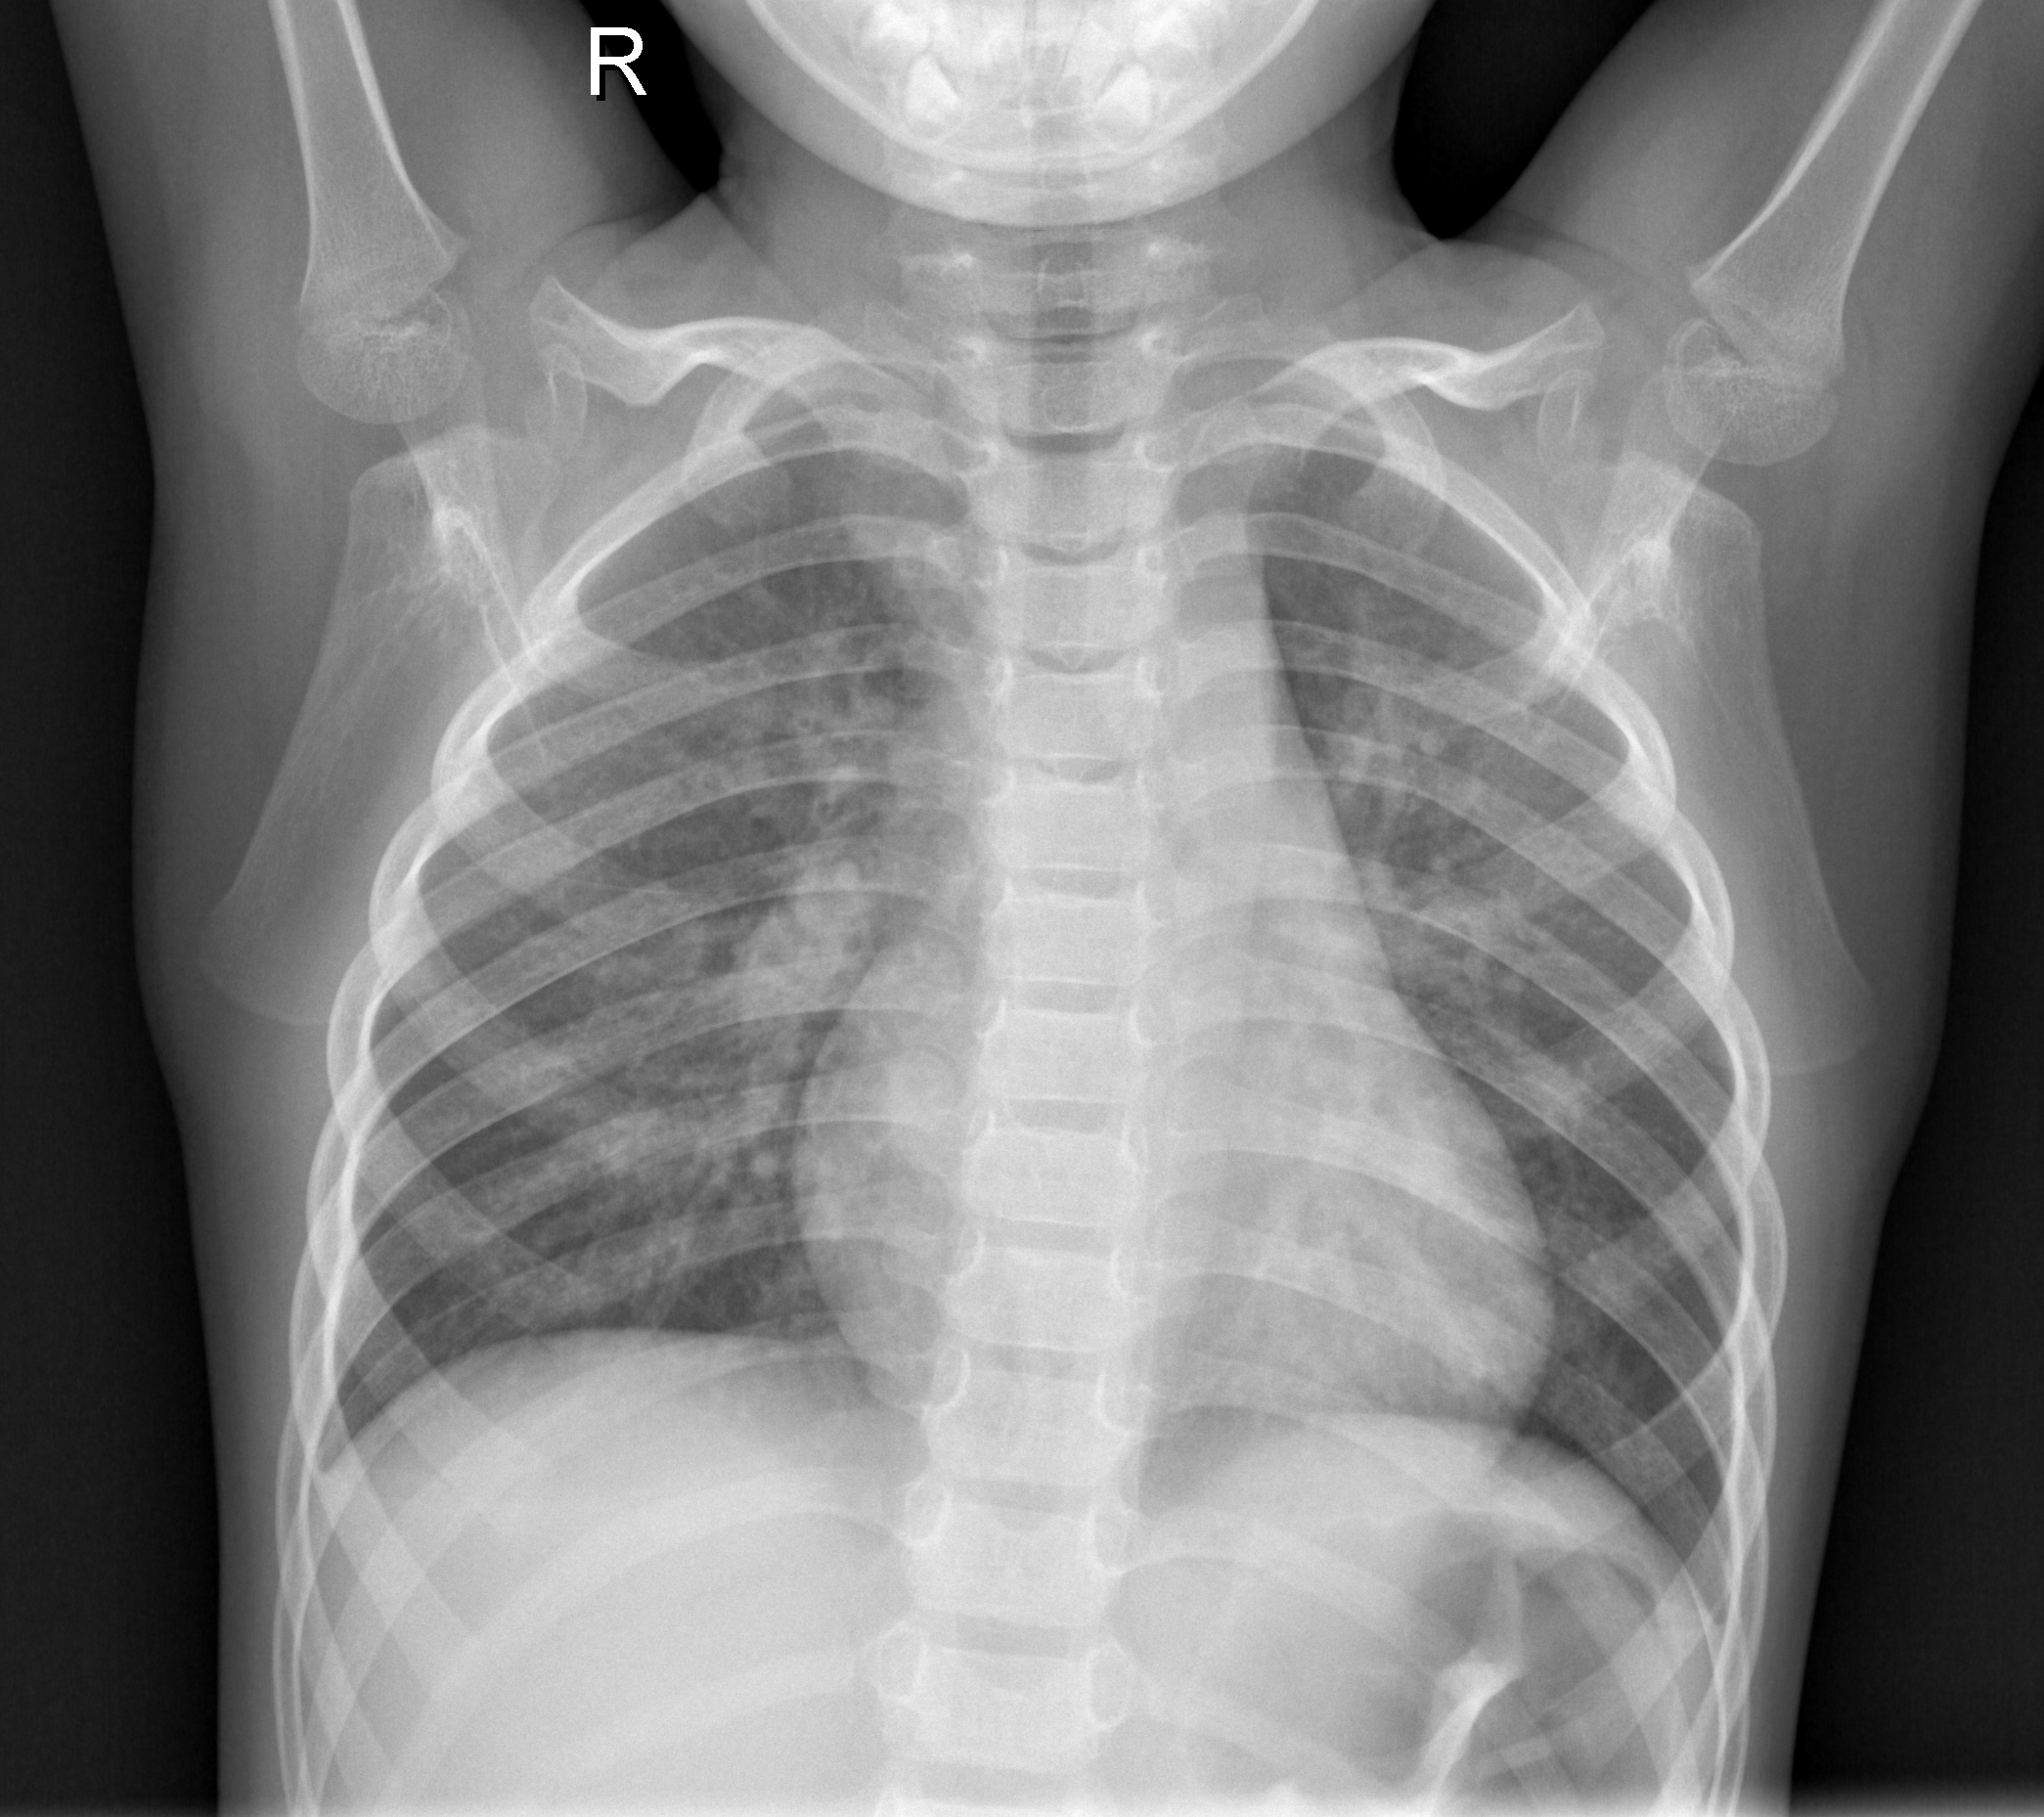

In [5]:
Image(filename='./data/chest_xray/train/NORMAL/IM-0115-0001.jpeg')

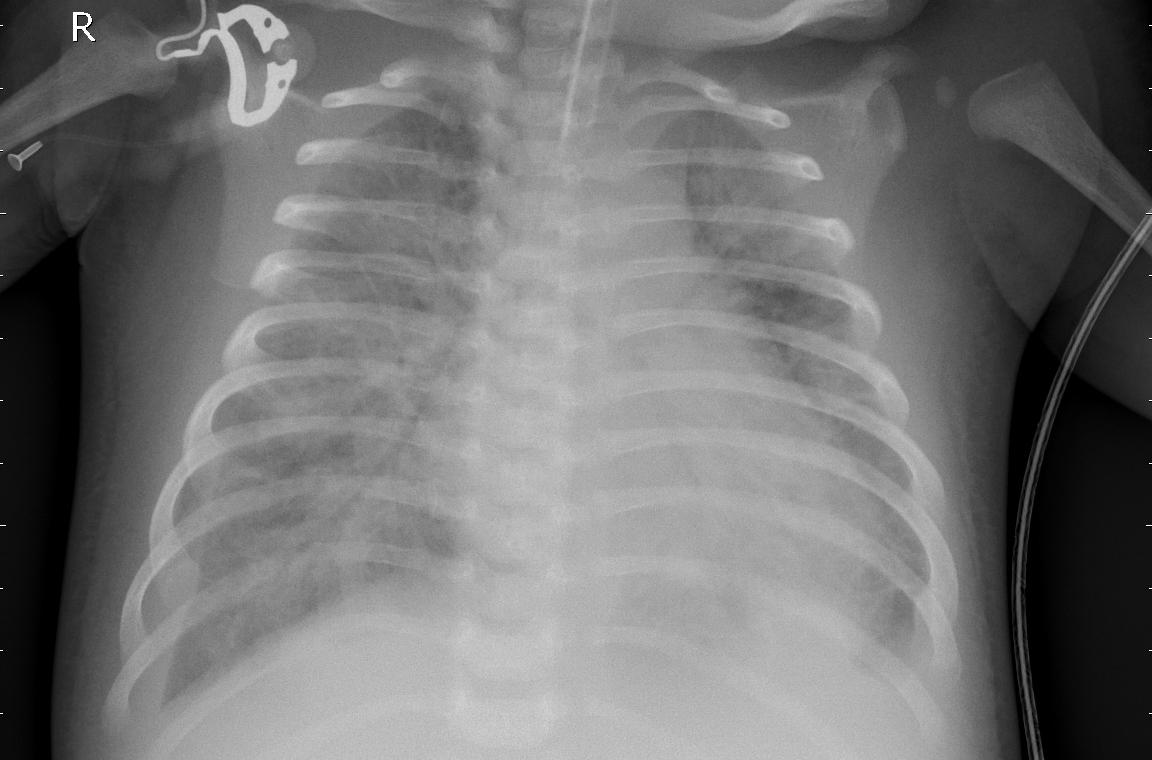

In [6]:
Image(filename='./data/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg')

In [7]:
Image(filename='./data/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg');

In [10]:
# Create an image generator for the training set. We are spliting a validation set off of this training set
trainGenerator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45, 
        width_shift_range=0.3,
        height_shift_range=0.3, 
        shear_range=0.2, 
        zoom_range=0.3,
        fill_mode='nearest', 
        horizontal_flip=True,
        vertical_flip=True,)

# Create an image generator for the training set. We are spliting a validation set off of this training set
testGenerator = ImageDataGenerator(rescale = 1./255, validation_split=.2)

In [9]:
# The flowed data from the directory for the training set. This will be fed directly into the neural networks
train = trainGenerator.flow_from_directory(
    trainPath, 
    class_mode='binary',
    target_size=(128,128),
    batch_size = 5216,)

# The split off validation set. This is fed directly into the neural networks
val = testGenerator.flow_from_directory(
    testPath, 
    class_mode='binary',
    target_size=(128,128),
    batch_size = 124,
    subset='validation'
)


# The flowed data from the directory for the testing set. This will be fed directly into the neural networks
test = testGenerator.flow_from_directory(
    testPath, 
    class_mode='binary',
    target_size=(128,128),
    batch_size = 500,
    subset = 'training'
)


Found 5216 images belonging to 2 classes.
Found 124 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [15]:
trainImages, trainImageLabels = next(train)
valImages, valImageLabels = next(val)
testImages, testImageLabels = next(test)

In [53]:
flatTrainImages = trainImages.reshape(5216,-1)
flatValImages = valImages.reshape(124 ,-1)
flatTestImages = testImages.reshape(500 ,-1)

# Save the shape of a flattened image in order to feed it into the model
inputShape = flatTrainImages.shape[1]

NameError: name 'trainImages' is not defined

# The Baseline Model

For the baseline model, this notebook will showcase the general method and explanations for how the neural network is being created. After this first round, several of the coding details will be left out or trimmed down. Rest assured the logic and decision making will still be expounded upon. 

Rather than using a truly dumb model to start off, we will build a very simpe perceptron with only one dense hidden layer. To keep the baseline model straight forward the dense layer will have 256 nodes that correspond to the dimension of the images it will be attempting to classify. There isn't any general sense that this methodology will yield better results, but it will suffice for a starting point for further iterations.

The hidden layer will utilize the "sigmoid" activation function which should be more appropriate for our scaled images, in which each pixel of information lies between the values of 0 and 1. 

The seaching parameters include stocastic gradient decent as the optimizing function, binary_crossentropy as the loss function and various metrics which we will use later on. Srocastic gradient decent (SGD) is the standard optimizer unless we have specific information which would drive us to other methods. As is true for the loss function. 

Metrics will be discussed at length after the model has been created in the baseline model evaluation section.

In [17]:
weights = compute_class_weight(
    'balanced',
    classes=[0, 1],
    y = train.labels
)

In [52]:
# We will be using the keras functional API for building models. 

# define the input layer
baselineModelInputs = Input((inputShape,), name = 'input_layer')

# define the first layer
x1 = layers.Dense(128, activation = 'sigmoid')(baselineModelInputs)

# define the ourput layer
baselineModelOutput = layers.Dense(1, activation = 'sigmoid')(x1)

# Create an instance of the keras.Model class with the input and outputs above
baselineModel = Model(inputs=baselineModelInputs, outputs = baselineModelOutput, name = 'baseline_model')

#compile the model
baselineModel.compile(
    optimizer = 'sgd',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

NameError: name 'inputShape' is not defined

In [19]:
# This cell defines the call backs we will use for most models. These functions cut down on the amount of time the 
# model takes to run and saves the best result for further use. 

# create the file path for where we want to save the resulting model
baseline_filepath = os.path.join('baseline_model')

# Create a call back that stops the modeling process early if there's no loss function improvement
# baselineEarlyStop = EarlyStopping(patience=4, mode = 'auto', restore_best_weights=True)

# create the call back that will save the best model created in the .fit method and save it to the file path above
# baselineModelCheckpoint = ModelCheckpoint(baseline_filepath,save_best_only=True, monitor = 'val_loss')

In [20]:
baselineModel.summary()

Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 16384)]           0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,097,409
Trainable params: 2,097,409
Non-trainable params: 0
_________________________________________________________________


In [21]:
# We fit the model, throwing in some basic parameters that will be tuned later. 
baselineHistory = baselineModel.fit(
    flatTrainImages,
    trainImageLabels,
    batch_size=32,
    epochs=100,
    validation_data=(flatValImages, valImageLabels),
    validation_steps=4,
    class_weight={0 : weights[0],1: weights[1]},
#     callbacks=[baselineEarlyStop, baselineModelCheckpoint]  
)

Train on 5216 samples, validate on 124 samples
Epoch 1/100
5216/5216 [==============================] - 1s 255us/sample - loss: 0.7082 - acc: 0.5305 - val_loss: 0.7121 - val_acc: 0.6290
Epoch 2/100
5216/5216 [==============================] - 1s 224us/sample - loss: 0.6841 - acc: 0.5729 - val_loss: 0.8493 - val_acc: 0.3468
Epoch 3/100
5216/5216 [==============================] - 1s 210us/sample - loss: 0.6777 - acc: 0.5707 - val_loss: 0.7598 - val_acc: 0.3871
Epoch 4/100
5216/5216 [==============================] - 1s 209us/sample - loss: 0.6745 - acc: 0.5813 - val_loss: 0.7634 - val_acc: 0.4516
Epoch 5/100
5216/5216 [==============================] - 1s 214us/sample - loss: 0.6707 - acc: 0.5945 - val_loss: 0.8009 - val_acc: 0.1855
Epoch 6/100
5216/5216 [==============================] - 1s 218us/sample - loss: 0.6657 - acc: 0.5984 - val_loss: 0.8331 - val_acc: 0.1694
Epoch 7/100
5216/5216 [==============================] - 1s 244us/sample - loss: 0.6633 - acc: 0.6062 - val_loss: 0.873

## Load Pre-Saved Baseline Model

In [9]:
# baselineModel = keras.models.load_model('./baseline_model/')

# Baseline Model Evaluation

## Evaluation Metrics

As pnumonia is a medical issue we will be using more metrics than usual when evaluating our models. This notebook will contain the following metrics when evaluating models. 
* Accuracy
* Recall
* F1
* Area Under the Curve (AUC)

### Accuracy

 For general interpretability, we include accuracy. Accuracy is the metric that best gives an answer to the question, "How does my model compare to an average guess." With this problem in particular, the data has a class imbalance. 

In [10]:
num_p = len([file for file in os.listdir('data./chest_xray/train/PNEUMONIA')])
num_n = len([file for file in os.listdir('data./chest_xray/train/NORMAL')])
print(f'Pneumonia images make up {round((num_p/(num_p+num_n))*100,2)}% of the total Images')
print(f'Normal images make up {round((num_n/(num_p+num_n))*100,2)}% of the total Images')

Pneumonia images make up 74.29% of the total Images
Normal images make up 25.71% of the total Images


The cell above suggest that if we weighted a random guess to the proportions of the samples we've been given, we should expect around 74% accuracy on average. In the following two cells, the model is evaluated over the train and test sets, to produce the metrics we are interested in exploring further.

In [11]:
# Get an evaluation set on the train data
trainEval = np.array(baselineModel.evaluate(flatTrainImages, trainImageLabels)).reshape(1,2)

NameError: name 'flatTrainImages' is not defined

In [12]:
# get an evaluation set on the test data
testEval = np.array(baselineModel.evaluate(flatValImages, valImageLabels)).reshape(1,2)

NameError: name 'flatValImages' is not defined

Looking at the accuracy of the testing set, the current neural net doesn't appear to be any better than a random guess. While disappointing first results, there's lots of room for improvement!

In [13]:
dfBaseline = pd.DataFrame().from_dict(baselineHistory.history)
dfBaseline

NameError: name 'baselineHistory' is not defined

KeyError: "None of [Index(['accuracy', 'val_accuracy'], dtype='object')] are in the [columns]"

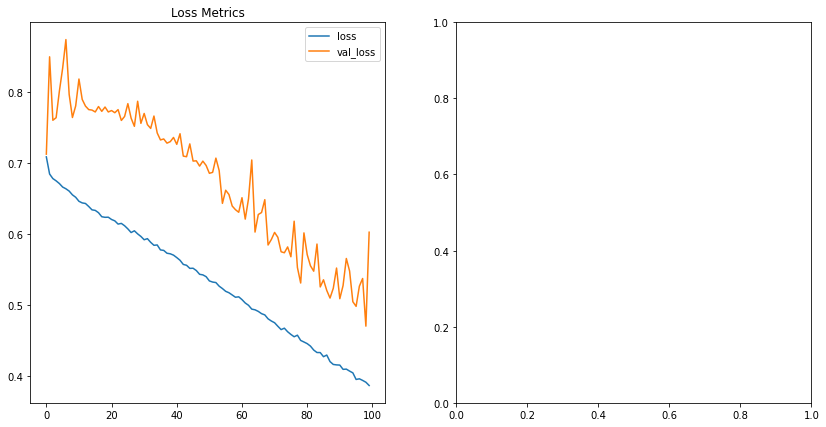

In [31]:
fig, ((ax1, ax2)) = plt.subplots(nrows = 1,ncols = 2, figsize = (14,7))
dfBaseline.plot(y = ['loss', 'val_loss'],ax = ax1, title = 'Loss Metrics');
dfBaseline.plot(y = ['accuracy', 'val_accuracy'],ax = ax2, title = 'Accuracy Metrics');

The graphs above could represent several issues with the model. For the image on the left, the loss function for the validation doesn't change on average over the 5 epochs, while the training loss continues downward roughly exponentially. The discrepancy is very likely do to overfitting of the training data. 

For the image on the right we see the training accuracy increasing logrithmicaly and the validation set ocillating around 75% accuracy. This is very likely do the simplicity of our model not being able to capture useful information about the images in the two dense layers in the baseline model. This is why we see the average accuracy very near what we would expect with a blind guess. The information the model picked up from the training set was particular enough to generalize to images it had never seen before.

For the following models, we will take a much deeper dive into model metrics (as well as indroduce several more). Considering this model is barely treding above a random guess, we will omit a more surgical analysis and move on to the next model. 

# Second Model

## Changes

The simple dense layer model used as the baseline wasn't taylored to image classification. There are, however, several other layer types that are much more adept at picking up on the data structure of images. The second model will rely on convulutional and pooling layers. 

A true deep dive into the underlying workings of these layers is beyond the scope of this notebook but we will sum them up for convienence. 

### Convulutional layers 

Convulutional layers are the life force of modern neural network image processing. Unlike dense layers which connect every piece of a 

### Pooling Layers

In [28]:
trainGenerator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45, 
        width_shift_range=0.3,
        height_shift_range=0.3, 
        shear_range=0.2, 
        zoom_range=0.3,
        fill_mode='nearest', 
        horizontal_flip=True,
        vertical_flip=True,)

# Create an image generator for the training set. We are spliting a validation set off of this training set
testGenerator = ImageDataGenerator(rescale = 1./255, validation_split=.2)

In [29]:
# The flowed data from the directory for the training set. This will be fed directly into the neural networks

train = trainGenerator.flow_from_directory(
    trainPath, 
    color_mode='grayscale', 
    class_mode='binary',
    target_size=(128,128),
    batch_size = 32,
)

# The split off validation set. This is fed directly into the neural networks
val = testGenerator.flow_from_directory(
    testPath, 
    color_mode='grayscale', 
    class_mode='binary',
    target_size=(128,128),
    batch_size = 32,
    subset='validation'
)


# The flowed data from the directory for the testing set. This will be fed directly into the neural networks
test = testGenerator.flow_from_directory(
    testPath, 
    color_mode='grayscale', 
    class_mode='binary',
    target_size=(128,128),
    batch_size = 32,
    subset='training'
)


Found 5216 images belonging to 2 classes.
Found 124 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [54]:
inputs = Input(shape = (128,128,1), name = 'input_layer')
x = layers.Conv2D(10, activation = 'relu',kernel_size = (3,3),padding = 'same' )(inputs)
x = layers.MaxPool2D(2, padding = 'same')(x)
x = layers.Conv2D(10, activation = 'relu',kernel_size = (3,3),padding = 'same' )(x)
x = layers.MaxPool2D(2, padding = 'same')(x)
x = layers.Flatten()(x)
x = layers.Dense(10, activation = 'relu')(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

secondModel = Model(inputs = inputs, outputs = outputs, name = 'second_model')

secondModel.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

In [55]:
secondModel.summary()

Model: "second_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 128, 128, 10)      100       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 64, 64, 10)        910       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 10)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 10240)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)               

In [56]:
secondModel_filepath = os.path.join('second_model')
secondModelEarlyStop = EarlyStopping(patience=9, mode = 'auto', restore_best_weights=True)
secondModelCheckpoint = ModelCheckpoint(secondModel_filepath,save_best_only=True)

In [57]:
secondModelHistory = secondModel.fit(
    train,
    batch_size=32,
    epochs=50,
    validation_data= (val),
    class_weight={0:weights[0], 1:weights[1]},
    callbacks=[secondModelCheckpoint, secondModelEarlyStop]
)

Epoch 1/50
 62/163 [==========>...................] - ETA: 28s - loss: 0.7034 - acc: 0.5176

KeyboardInterrupt: 

# Second Model Evaluation

In [164]:
secondModel.evaluate(train)
secondModel.evaluate(val)

4/4 [==============================] - 1s 178ms/step - loss: 0.1776 - acc: 0.9516


[0.1776094138622284, 0.9516128897666931]

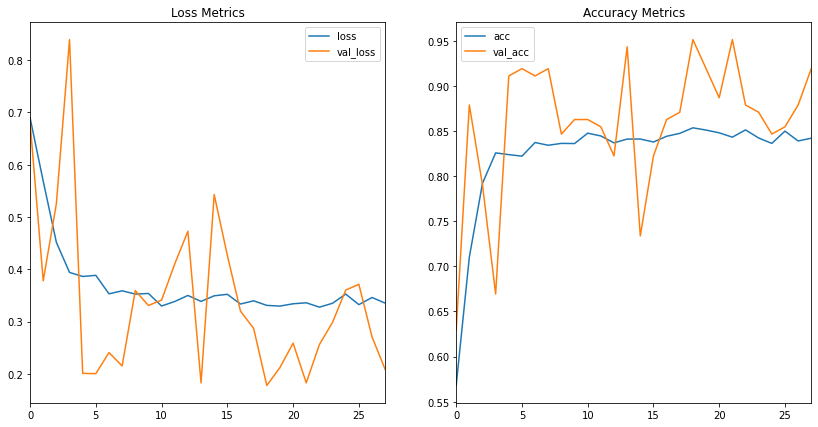

In [165]:
dfSecondModel = pd.DataFrame().from_dict(secondModelHistory.history)

fig, ((ax1, ax2)) = plt.subplots(nrows = 1,ncols = 2, figsize = (14,7))
dfSecondModel.plot(y = ['loss', 'val_loss'],ax = ax1, title = 'Loss Metrics');
dfSecondModel.plot(y = ['acc', 'val_acc'],ax = ax2, title = 'Accuracy Metrics');

Once again we add some callback functions for efficiancy and reusability. 

In [167]:
def confustion_matrix(y, y_hat, normalize = 'true'):
    fig, ax = plt.subplots(1,1,figsize = (7,6))
    matrix = skm.confusion_matrix(y, y_hat, normalize=normalize,)
    sns.heatmap(matrix, cmap = 'Blues', annot=True, ax = ax)
    ax.set(
        title = 'Confustion Matrix'
    )

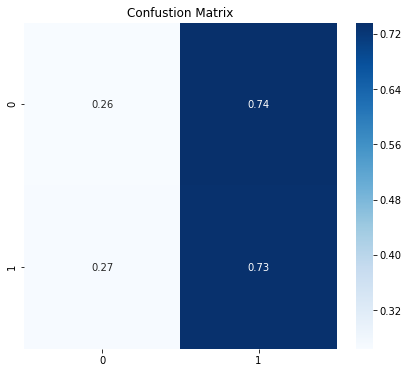

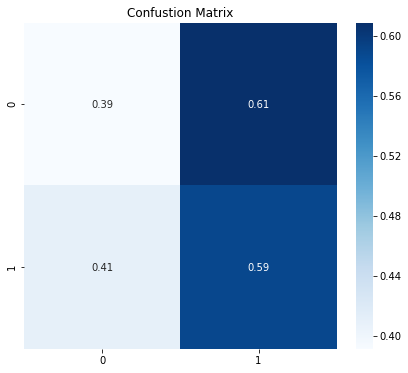

In [168]:
y_hat_train = secondModel.predict(train).round()
y_train = train.labels
y_hat_val = secondModel.predict(val).round()
y_val = val.labels
confustion_matrix(y_train, y_hat_train)
confustion_matrix(y_val, y_hat_val)

The second model was much more stable. Metrics aren't that impressive which means we are likely dealing with training overfitting. There are several prescribed methods to handle overfitting but we will explore some more detailed metrics to see if we can tease out what part of our model is preforming incorrectly. 

# Third Model

## Changes

The 

In [174]:
inputs = Input(shape = (128,128,1), name = 'input_layer')
x = layers.Conv2D(10,kernel_size = (3,3), padding = 'same', activation = 'relu')(inputs)
x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
x = layers.MaxPool2D(2, padding = 'same')(x)
x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
x = layers.MaxPool2D(2, padding = 'same')(x)
x = layers.Flatten()(x)
x = layers.Dense(10, activation = 'relu')(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)  

thirdModel = Model(inputs = inputs, outputs = outputs, name = 'third_model')

thirdModel.compile(
    optimizer =  'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
thirdModel.summary()

Model: "third_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 128, 128, 10)      100       
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 128, 128, 10)      910       
_________________________________________________________________
max_pooling2d_173 (MaxPoolin (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_236 (Conv2D)          (None, 64, 64, 10)        910       
_________________________________________________________________
conv2d_237 (Conv2D)          (None, 64, 64, 10)        910       
_________________________________________________________________
max_pooling2d_174 (MaxPoolin (None, 32, 32, 10)        

In [175]:
thirdModel_filepath = os.path.join('third_model')
thirdModelEarlyStop = EarlyStopping(patience=9, mode = 'auto', restore_best_weights=True)
thirdModelCheckpoint = ModelCheckpoint(thirdModel_filepath,save_best_only=True)

In [176]:
thirdModelHistory = thirdModel.fit(
    train, 
    batch_size=32,
    epochs=50,
    validation_data= val,
    validation_steps=3,
    class_weight = {0:weights[0], 1:weights[1]},
    callbacks=[thirdModelEarlyStop, thirdModelCheckpoint])

Epoch 1/50
163/163 [==============================] - 61s 377ms/step - loss: 0.6937 - accuracy: 0.5084 - val_loss: 0.6945 - val_accuracy: 0.5104
Epoch 2/50
163/163 [==============================] - 61s 373ms/step - loss: 0.6507 - accuracy: 0.6114 - val_loss: 0.7107 - val_accuracy: 0.5417
Epoch 3/50
163/163 [==============================] - 62s 383ms/step - loss: 0.5821 - accuracy: 0.6875 - val_loss: 0.8375 - val_accuracy: 0.5000
Epoch 4/50
163/163 [==============================] - 62s 381ms/step - loss: 0.5307 - accuracy: 0.7134 - val_loss: 0.8401 - val_accuracy: 0.5938
Epoch 5/50
163/163 [==============================] - 63s 386ms/step - loss: 0.5089 - accuracy: 0.7350 - val_loss: 0.5646 - val_accuracy: 0.6458
Epoch 6/50
163/163 [==============================] - 62s 380ms/step - loss: 0.4922 - accuracy: 0.7368 - val_loss: 0.6665 - val_accuracy: 0.6250
Epoch 7/50
163/163 [==============================] - 63s 384ms/step - loss: 0.4536 - accuracy: 0.7749 - val_loss: 0.6719 - val_ac

In [177]:
thirdModel.evaluate(train)
thirdModel.evaluate(val)

4/4 [==============================] - 1s 179ms/step - loss: 0.2530 - accuracy: 0.8871


[0.252969890832901, 0.8870967626571655]

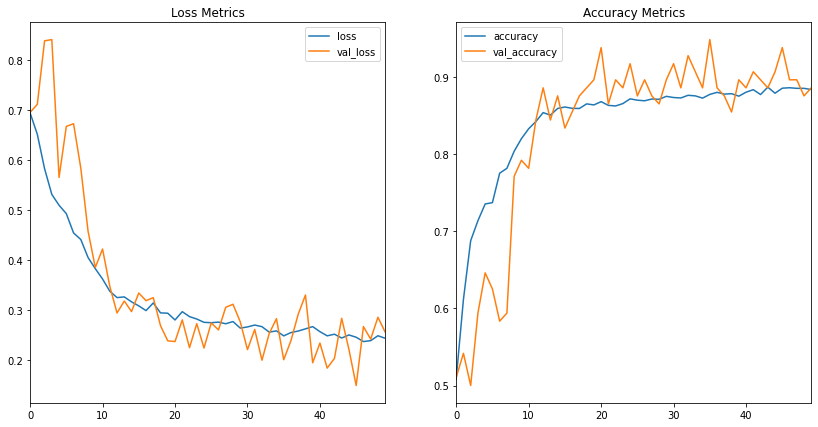

In [178]:
dfThirdModel = pd.DataFrame.from_dict(thirdModelHistory.history)
fig, ((ax1, ax2)) = plt.subplots(nrows = 1,ncols = 2, figsize = (14,7))
dfThirdModel.plot(y = ['loss', 'val_loss'],ax = ax1, title = 'Loss Metrics');
dfThirdModel.plot(y = ['accuracy', 'val_accuracy'],ax = ax2, title = 'Accuracy Metrics');

In [64]:
y3_hat_train = thirdModel.predict(train, verbose = True).round()
y3_train = train.labels

y3_hat_val = thirdModel.predict(val, verbose = True).round()
y3_val = val.labels

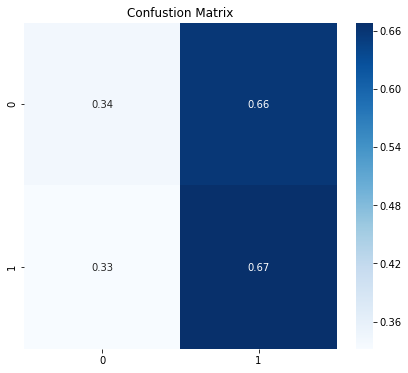

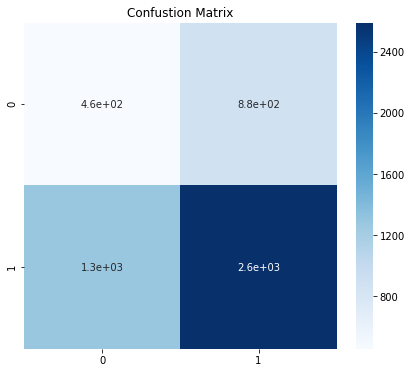

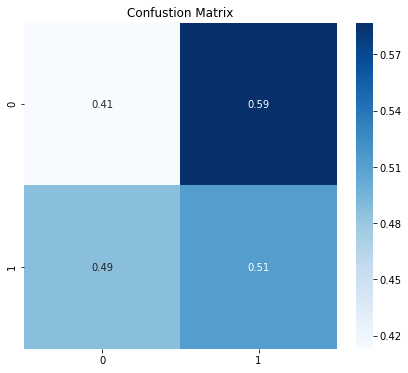

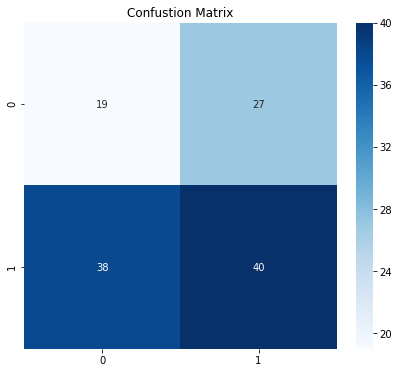

In [66]:
confustion_matrix(y3_train, y3_hat_train)
confustion_matrix(y3_train, y3_hat_train, normalize=None)
confustion_matrix(y3_val, y3_hat_val)
confustion_matrix(y3_val, y3_hat_val, normalize=None)

## Adjustments to the Third Model

Erratic behavior from first run. We are going to change the optimizer to rmsprop to add inertia to the loss function. We will also be adding L2 regularization to the layers before the max pooling layers in an attempt to disuade the jagged spikes in the loss. 

In [30]:
inputs = Input(shape = (128,128,1), name = 'input_layer')
x = layers.Conv2D(10,kernel_size = (3,3), padding = 'same', activation = 'relu')(inputs)
x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
# x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
# x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
# x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
# x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
# x = layers.MaxPool2D(2, padding = 'same')(x)
# x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
# x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
# x = layers.MaxPool2D(2, padding = 'same')(x)
# x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
# x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
# x = layers.MaxPool2D(2, padding = 'same')(x)
# x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
# x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
# x = layers.MaxPool2D(2, padding = 'same')(x)
x = layers.Flatten()(x)
# x = layers.Dense(10, activation = 'relu')(x)
# x = layers.Dense(10, activation = 'relu')(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)  

thirdModel2 = Model(inputs = inputs, outputs = outputs, name = 'third_model')

thirdModel2.compile(
    optimizer =  'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
thirdModel2.summary()

Model: "third_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 10)      100       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 163840)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 163841    
Total params: 164,851
Trainable params: 164,851
Non-trainable params: 0
_________________________________________________________________


In [31]:
thirdModel2_filepath = os.path.join('third_model2')
thirdModel2EarlyStop = EarlyStopping(patience=20, mode = 'auto', restore_best_weights=True)
thirdModel2Checkpoint = ModelCheckpoint(thirdModel2_filepath,save_best_only=True)

In [32]:
thirdModel2History = thirdModel2.fit(
    train, 
    batch_size=32,
    epochs=50,
    validation_data= val,
    class_weight = {0:weights[0], 1:weights[1]},
    callbacks=[thirdModel2EarlyStop, thirdModel2Checkpoint])

Epoch 1/50
163/163 [==============================] - 55s 340ms/step - loss: 0.6400 - accuracy: 0.6530 - val_loss: 0.6201 - val_accuracy: 0.5887
Epoch 2/50
163/163 [==============================] - 57s 347ms/step - loss: 0.4730 - accuracy: 0.7709 - val_loss: 0.4731 - val_accuracy: 0.7581
Epoch 3/50
163/163 [==============================] - 55s 340ms/step - loss: 0.4452 - accuracy: 0.7855 - val_loss: 0.3151 - val_accuracy: 0.8710
Epoch 4/50
163/163 [==============================] - 56s 341ms/step - loss: 0.4044 - accuracy: 0.8102 - val_loss: 0.3454 - val_accuracy: 0.8710
Epoch 5/50
163/163 [==============================] - 55s 338ms/step - loss: 0.3886 - accuracy: 0.8156 - val_loss: 0.5242 - val_accuracy: 0.6452
Epoch 6/50
163/163 [==============================] - 55s 340ms/step - loss: 0.3721 - accuracy: 0.8305 - val_loss: 0.2831 - val_accuracy: 0.9032
Epoch 7/50
163/163 [==============================] - 55s 338ms/step - loss: 0.3795 - accuracy: 0.8252 - val_loss: 0.2557 - val_ac

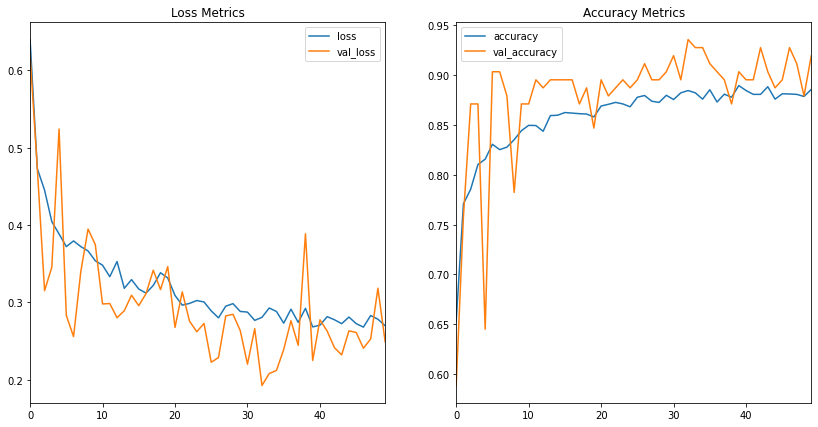

In [34]:
dfThirdModel2 = pd.DataFrame.from_dict(thirdModel2History.history)
fig, ((ax1, ax2)) = plt.subplots(nrows = 1,ncols = 2, figsize = (14,7))
dfThirdModel2.plot(y = ['loss', 'val_loss'],ax = ax1, title = 'Loss Metrics');
dfThirdModel2.plot(y = ['accuracy', 'val_accuracy'],ax = ax2, title = 'Accuracy Metrics');

In [35]:
thirdModel2.evaluate(train)
thirdModel2.evaluate(val)

4/4 [==============================] - 1s 174ms/step - loss: 0.2488 - accuracy: 0.9194


[0.24878188967704773, 0.9193548560142517]

163/163 [==============================] - 48s 294ms/step


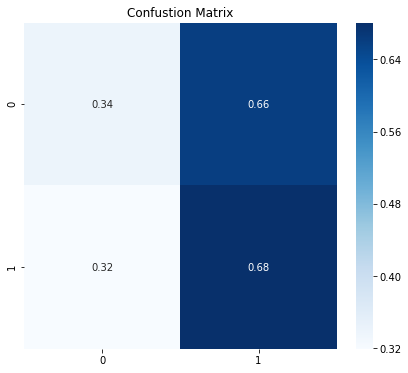

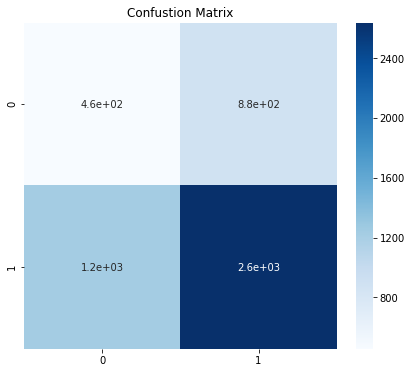

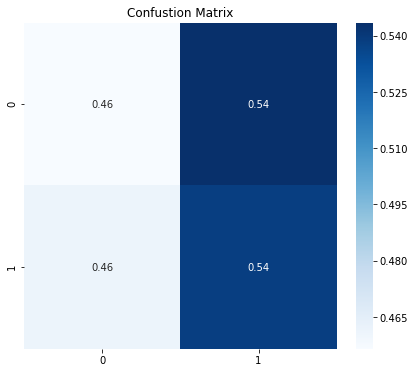

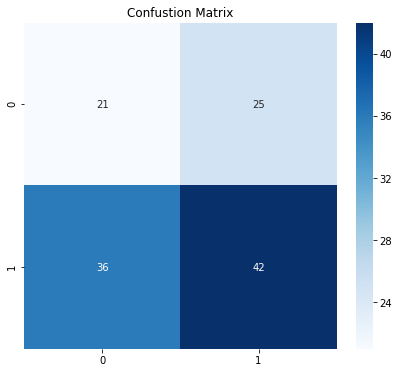

In [201]:
y3_hat2_train = thirdModel2.predict(train, verbose=True).round()
y3_hat2_val = thirdModel2.predict(val).round()

confustion_matrix(train.labels, y3_hat2_train)
confustion_matrix(train.labels, y3_hat2_train, normalize=None)
confustion_matrix(val.labels, y3_hat2_val)
confustion_matrix(val.labels, y3_hat2_val, normalize=None)

# Fourth Model

In [47]:
inputs = Input(shape = (128,128,1), name = 'input_layer')
x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(inputs)
# x = layers.BatchNormalization(axis = 3, scale = True)(x)
x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu' )(x)
# x = layers.BatchNormalization(axis = 3, scale = True)(x)
# x = layers.MaxPool2D(2, padding = 'same')(x)
x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu',)(x)
# x = layers.BatchNormalization(axis = 3, scale = True)(x)
# x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu',)(x)
# x = layers.BatchNormalization(axis = 3, scale = True)(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
# x = layers.BatchNormalization(axis = 3, scale = True)(x)
x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
x = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', activation = 'relu')(x)
# x = layers.BatchNormalization(axis = 3, scale = True)(x)
# x = layers.MaxPool2D(2, padding = 'same')(x)
x = layers.Flatten()(x)
# x = layers.Dropout(.3)(x)
x = layers.Dense(4, activation = 'relu')(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

fourthModel = Model(inputs = inputs, outputs = outputs, name = 'fourth_model')
fourthModel.compile(
    optimizer =  'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
    )
fourthModel.summary()

Model: "fourth_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 128, 128, 10)      100       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 128, 128, 10)      910       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 128, 128, 10)      910       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 64, 64, 10)        910       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 64, 64, 10)       

In [48]:
fourthModel_filepath = os.path.join('fourth_model')
fourthModelEarlyStop = EarlyStopping(patience=10, mode = 'auto',  restore_best_weights=True)
fourthModelCheckpoint = ModelCheckpoint(fourthModel_filepath,save_best_only=True)

In [50]:
fourthModelHistory = fourthModel.fit(
    train, 
    batch_size=64,
    epochs=60,
    validation_data= val,
    class_weight = {0:weights[0], 1:weights[1]},
    callbacks=[fourthModelEarlyStop, fourthModelCheckpoint])

Epoch 1/60
163/163 [==============================] - 77s 474ms/step - loss: 0.4467 - accuracy: 0.7755 - val_loss: 0.3481 - val_accuracy: 0.8710
Epoch 2/60
163/163 [==============================] - 77s 472ms/step - loss: 0.4265 - accuracy: 0.7914 - val_loss: 0.3555 - val_accuracy: 0.8710
Epoch 3/60
163/163 [==============================] - 77s 470ms/step - loss: 0.4176 - accuracy: 0.7952 - val_loss: 0.4375 - val_accuracy: 0.7581
Epoch 4/60
163/163 [==============================] - 76s 464ms/step - loss: 0.3769 - accuracy: 0.8305 - val_loss: 0.3374 - val_accuracy: 0.8710
Epoch 5/60
163/163 [==============================] - 72s 439ms/step - loss: 0.3486 - accuracy: 0.8528 - val_loss: 0.3767 - val_accuracy: 0.8226
Epoch 6/60
163/163 [==============================] - 72s 444ms/step - loss: 0.3351 - accuracy: 0.8518 - val_loss: 0.3625 - val_accuracy: 0.8548
Epoch 7/60
163/163 [==============================] - 72s 439ms/step - loss: 0.3351 - accuracy: 0.8545 - val_loss: 0.3840 - val_ac

In [41]:
fourthModel.evaluate(train)
fourthModel.evaluate(val)

4/4 [==============================] - 1s 186ms/step - loss: 0.2642 - accuracy: 0.9194


[0.26421722769737244, 0.9193548560142517]

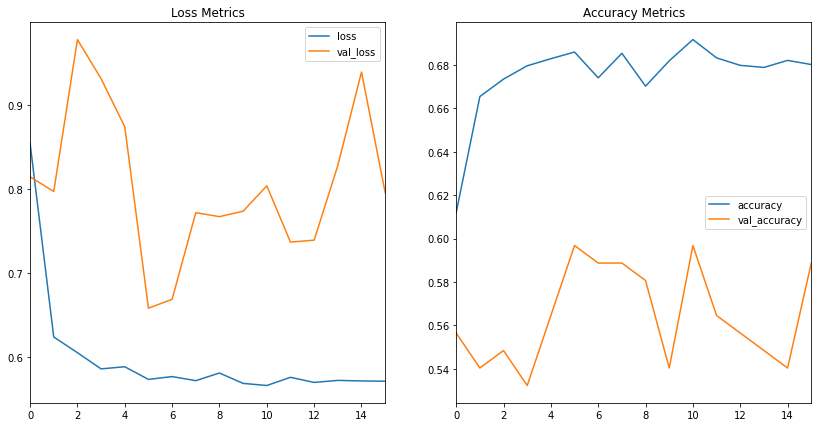

In [103]:
dfFourthModel = pd.DataFrame.from_dict(fourthModelHistory.history)
fig, ((ax1, ax2)) = plt.subplots(nrows = 1,ncols = 2, figsize = (14,7))
dfFourthModel.plot(y = ['loss', 'val_loss'],ax = ax1, title = 'Loss Metrics');
dfFourthModel.plot(y = ['accuracy', 'val_accuracy'],ax = ax2, title = 'Accuracy Metrics');

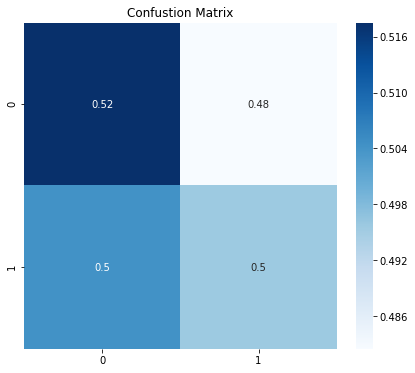

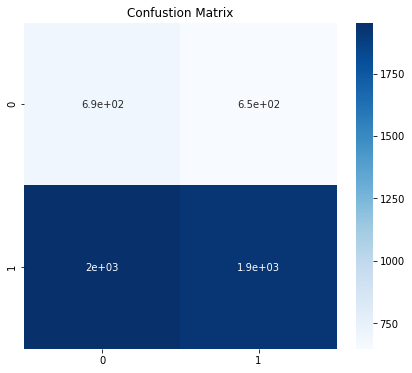

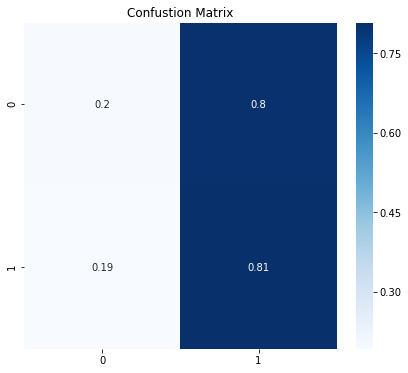

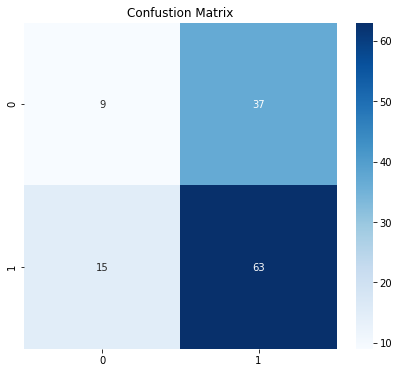

In [104]:
y4_hat_train = fourthModel.predict(train).round()
y4_train = train.labels
y4_hat_val = fourthModel.predict(val).round()
y4_val = val.labels

confustion_matrix(y4_train, y4_hat_train)
confustion_matrix(y4_train, y4_hat_train, normalize = None)
confustion_matrix(y4_val, y4_hat_val)
confustion_matrix(y4_val, y4_hat_val, normalize=None)

In [105]:
fourthModel.evaluate(test)

16/16 [==============================] - 3s 211ms/step - loss: 0.6092 - accuracy: 0.6400


[0.6091538667678833, 0.6399999856948853]

# Fifth Model

In [223]:
inputs = Input(shape = (128,128,1), name = 'input_layer')
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same', strides = 1)(inputs)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.ReLU()(x)
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same', strides = 1, kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.ReLU()(x)
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same', strides=1)(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.ReLU()(x)
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same', strides = 2, kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.ReLU()(x)
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same',strides = 2, )(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.ReLU()(x)
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same',strides = 2, kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.ReLU()(x)
x = layers.Conv2D(27,kernel_size = (3,3),padding = 'same',strides = 2 )(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.ReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

fifthModel = Model(inputs = inputs, outputs = outputs, name = 'fifth_model')

fifthModel.compile(
    optimizer =  'nadam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

fifthModel.summary()

Model: "fifth_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 128, 128, 27)      270       
_________________________________________________________________
batch_normalization_60 (Batc (None, 128, 128, 27)      81        
_________________________________________________________________
re_lu_89 (ReLU)              (None, 128, 128, 27)      0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 128, 128, 27)      6588      
_________________________________________________________________
batch_normalization_61 (Batc (None, 128, 128, 27)      81        
_________________________________________________________________
re_lu_90 (ReLU)              (None, 128, 128, 27)      

In [ ]:
fifthModel_filepath = os.path.join('fifth_model')
fifthModelEarlyStop = EarlyStopping(patience=6, mode = 'auto', restore_best_weights = True)
fifthModelCheckpoint = ModelCheckpoint(fifthModel_filepath,save_best_only=True)

In [ ]:
fifthModelHistory = fifthModel.fit(
    train, 
    batch_size=64,
    epochs=25,
    validation_data= val,
    class_weight = {0:weights[0], 1:weights[1]},
    callbacks=[fifthModelEarlyStop, fifthModelCheckpoint])

In [ ]:
fifthModel.model.evaluate(train)
fifthModel.model.evaluate(val)

In [ ]:
# y5_hat_train = fifthModel.predict(trainImages)
# y5_train = trainImageLabels
# confustion_matrix(y5_train, y5_hat_train)
# y5_hat_val = fifthModel.predict(valImages)
# y5_val = valImageLabels
# confustion_matrix(y5_val, y5_hat_val)
# confustion_matrix(y5_val, y5_hat_val, normalize=None)

# Experimental Modles

## Residual Net

In [144]:
inputs = Input(shape = (128,128,1), name = 'input_layer')
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same', strides=1, activation = 'relu')(inputs)
# x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)

resid1 = layers.Conv2D(20,kernel_size = (3,3),padding = 'same', strides = 2)(x)
# x = layers.BatchNormalization(axis = 3, scale = False)(resid1)
x = layers.LeakyReLU(.3)(resid1)
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same', strides = 1, kernel_regularizer = 'l2')(x)
# x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same', strides=1)(x)
# x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)

block1 = layers.add([resid1,x])
resid2 = layers.Conv2D(20,kernel_size = (3,3),padding = 'same', strides = 2, kernel_regularizer = 'l2')(block1)
# x = layers.BatchNormalization(axis = 3, scale = False)(resid2)
x = layers.LeakyReLU(.3)(resid2)
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 1, kernel_regularizer = 'l2')(x)
# x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)

block2 = layers.add([x, resid2])
resid3 = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 2)(block2)
# x = layers.BatchNormalization(axis = 3, scale = False)(resid3)
x = layers.LeakyReLU(.3)(resid3)
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 1)(x)
# x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)

block3 = layers.add([x, resid3])
resid4 = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 2)(block3)
# x = layers.BatchNormalization(axis = 3, scale = False)(resid4)
x = layers.LeakyReLU(.3)(resid4)
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 1)(x)
# x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)

block4 = layers.add([x, resid4])
resid5 = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 2)(block4)
# x = layers.BatchNormalization(axis = 3, scale = False)(resid5)
x = layers.LeakyReLU(.3)(resid5)
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 1)(x)
# x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dense(10, activation = 'relu')(x)
# x = layers.Dropout(.3)(x)
# x = layers.LeakyReLU()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

experimentalModel1 = Model(inputs = inputs, outputs = outputs, name = 'experimental_model_1')
experimentalModel1.summary()

Model: "experimental_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, 128, 128, 20) 200         input_layer[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_84 (LeakyReLU)      (None, 128, 128, 20) 0           conv2d_132[0][0]                 
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 64, 64, 20)   3620        leaky_re_lu_84[0][0]             
_______________________________________________________________________________

In [145]:
experimentalModel1.compile(
    optimizer =  'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [146]:
experimental1Model_filepath = os.path.join('exmodel1')
experimental1ModelEarlyStop = EarlyStopping(patience=9, mode = 'auto', restore_best_weights=True)
experimental1ModelCheckpoint = ModelCheckpoint(experimental1Model_filepath,save_best_only=True)

In [147]:
exHistory = experimentalModel1.fit(
    train,
    epochs=50,
    batch_size=32,
    validation_data=val,
    class_weight = {0:weights[0], 1:weights[1]},
    callbacks=[experimental1ModelCheckpoint, experimental1ModelEarlyStop]
)

Epoch 1/50
163/163 [==============================] - 67s 410ms/step - loss: 0.8204 - accuracy: 0.5345 - val_loss: 0.6918 - val_accuracy: 0.6290
Epoch 2/50
163/163 [==============================] - 65s 397ms/step - loss: 0.6933 - accuracy: 0.7429 - val_loss: 0.6920 - val_accuracy: 0.6290
Epoch 3/50
163/163 [==============================] - 65s 397ms/step - loss: 0.6932 - accuracy: 0.7383 - val_loss: 0.6929 - val_accuracy: 0.6290
Epoch 4/50
163/163 [==============================] - 65s 397ms/step - loss: 0.6932 - accuracy: 0.7429 - val_loss: 0.6930 - val_accuracy: 0.6290
Epoch 5/50
 66/163 [===========>..................] - ETA: 37s - loss: 0.6916 - accuracy: 0.5440

KeyboardInterrupt: 

In [ ]:
experimentalModel1.evaluate(train)
experimentalModel1.evaluate(val)

In [ ]:
dfEx1Model = pd.DataFrame.from_dict(exHistory.history)
fig, ((ax1, ax2)) = plt.subplots(nrows = 1,ncols = 2, figsize = (14,7))
dfEx1Model.plot(y = ['loss', 'val_loss'],ax = ax1, title = 'Loss Metrics');
dfEx1Model.plot(y = ['accuracy', 'val_accuracy'],ax = ax2, title = 'Accuracy Metrics');

In [ ]:
yex1_hat_train = experimentalModel1.predict(train).round()
yex1_train = train.labels
confustion_matrix(yex1_train, yex1_hat_train)
yex1_hat_val = experimentalModel1.predict(val).round()
yex1_val = val.labels
confustion_matrix(yex1_val, yex1_hat_val)
confustion_matrix(yex1_val, yex1_hat_val, normalize=None)

In [ ]:
experimentalModel1.evaluate(test)

## Multiple Inputs

In [104]:
inputs = Input(shape = (128,128,1), name = 'input_layer')
x1 = layers.Conv2D(10,kernel_size = (15,15),padding = 'same', strides=1, activation = 'relu')(inputs)
x1 = layers.MaxPool2D(2, padding = 'same')(x1)
x1 = layers.Conv2D(10,kernel_size = (15,15),padding = 'same', strides=1, activation = 'relu')(x1)
x1 = layers.MaxPool2D(2, padding = 'same')(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(10, activation = 'relu')(x1)
x1 = layers.Dense(1, activation = 'sigmoid')(x1)

x2 = layers.Conv2D(10,kernel_size = (11,11),padding = 'same', strides=1, activation = 'relu')(inputs)
x2 = layers.MaxPool2D(2, padding = 'same')(x2)
x2 = layers.Conv2D(10,kernel_size = (11,11),padding = 'same', strides=1, activation = 'relu')(x2)
x2 = layers.MaxPool2D(2, padding = 'same')(x2)
x2 = layers.Flatten()(x2)
x2 = layers.Dense(10, activation = 'relu')(x2)
x2 = layers.Dense(1, activation = 'sigmoid')(x2)

x3 = layers.Conv2D(10,kernel_size = (7,7),padding = 'same', strides=1, activation = 'relu')(inputs)
x3 = layers.MaxPool2D(2, padding = 'same')(x3)
x3 = layers.Conv2D(10,kernel_size = (7,7),padding = 'same', strides=1, activation = 'relu')(x3)
x3 = layers.MaxPool2D(2, padding = 'same')(x3)
x3 = layers.Flatten()(x3)
x3 = layers.Dense(10, activation = 'relu')(x3)
x3 = layers.Dense(1, activation = 'sigmoid')(x3)

x4 = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', strides=1, activation = 'relu')(inputs)
x4 = layers.MaxPool2D(2, padding = 'same')(x4)
x4 = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', strides=1, activation = 'relu')(x4)
x4 = layers.MaxPool2D(2, padding = 'same')(x4)
x4 = layers.Flatten()(x4)
x4 = layers.Dense(10, activation = 'relu')(x4)
x4 = layers.Dense(1, activation = 'sigmoid')(x4)


block1 = layers.add([x1, x2, x3, x4])

# x = layers.MaxPool2D(2, padding = 'same')(block1)
# x = layers.Conv2D(10, kernel_size = (3,3),padding = 'same', strides=1, activation = 'relu')(x)
# x = layers.MaxPool2D(2, padding = 'same')(x)
# x = layers.Flatten()(x)
x = layers.Dense(4, activation = 'relu')(block1)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

experimentalModel2 = Model(inputs = inputs, outputs = outputs, name = 'experimental_model_1')
experimentalModel2.summary()

Model: "experimental_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 128, 128, 10) 2260        input_layer[0][0]                
__________________________________________________________________________________________________
conv2d_170 (Conv2D)             (None, 128, 128, 10) 1220        input_layer[0][0]                
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 128, 128, 10) 500         input_layer[0][0]                
_______________________________________________________________________________

In [105]:
experimentalModel2.compile(
    optimizer =  'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [106]:
experimental2Model_filepath = os.path.join('exmodel2')
experimental2ModelEarlyStop = EarlyStopping(patience=9, mode = 'auto', restore_best_weights=True)
experimental2ModelCheckpoint = ModelCheckpoint(experimental2Model_filepath,save_best_only=True)

In [107]:
exHistory = experimentalModel2.fit(
    train,
    epochs=50,
    batch_size=32,
    validation_data=val,
    class_weight = {0:weights[0], 1:weights[1]},
    callbacks=[experimental2ModelCheckpoint, experimental2ModelEarlyStop]
)

Epoch 1/50
163/163 [==============================] - 246s 2s/step - loss: 0.6966 - accuracy: 0.7235 - val_loss: 0.6923 - val_accuracy: 0.6290
Epoch 2/50
163/163 [==============================] - 241s 1s/step - loss: 0.6932 - accuracy: 0.4365 - val_loss: 0.6920 - val_accuracy: 0.6290
Epoch 3/50
163/163 [==============================] - 238s 1s/step - loss: 0.6932 - accuracy: 0.7429 - val_loss: 0.6926 - val_accuracy: 0.6290
Epoch 4/50
163/163 [==============================] - 238s 1s/step - loss: 0.6932 - accuracy: 0.5485 - val_loss: 0.6926 - val_accuracy: 0.6290
Epoch 5/50
163/163 [==============================] - 238s 1s/step - loss: 0.6932 - accuracy: 0.7352 - val_loss: 0.6925 - val_accuracy: 0.6290
Epoch 6/50
101/163 [=================>............] - ETA: 1:32 - loss: 0.6954 - accuracy: 0.7404

KeyboardInterrupt: 

## Experimental 3

In [111]:
inputs = Input(shape = (128,128,1), name = 'input_layer')
x1 = layers.Conv2D(10,kernel_size = (15,15),padding = 'same', strides=1, activation = 'relu')(inputs)
x1 = layers.MaxPool2D(2, padding = 'same')(x1)

x2 = layers.Conv2D(10,kernel_size = (11,11),padding = 'same', strides=1, activation = 'relu')(inputs)
x2 = layers.MaxPool2D(2, padding = 'same')(x2)

x3 = layers.Conv2D(10,kernel_size = (7,7),padding = 'same', strides=1, activation = 'relu')(inputs)
x3 = layers.MaxPool2D(2, padding = 'same')(x3)

x4 = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', strides=1, activation = 'relu')(inputs)
x4 = layers.MaxPool2D(2, padding = 'same')(x4)

block1 = layers.add([x1, x2, x3, x4])

x1 = layers.Conv2D(10,kernel_size = (15,15),padding = 'same', strides=1, activation = 'relu')(block1)
x1 = layers.MaxPool2D(2, padding = 'same')(x1)


x2 = layers.Conv2D(10,kernel_size = (11,11),padding = 'same', strides=1, activation = 'relu')(block1)
x2 = layers.MaxPool2D(2, padding = 'same')(x2)


x3 = layers.Conv2D(10,kernel_size = (7,7),padding = 'same', strides=1, activation = 'relu')(block1)
x3 = layers.MaxPool2D(2, padding = 'same')(x3)


x4 = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', strides=1, activation = 'relu')(block1)
x4 = layers.MaxPool2D(2, padding = 'same')(x4)

block2 = layers.add([x1, x2, x3, x4])
x = layers.Flatten()(block2)
x = layers.Dense(10, activation = 'relu')(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

experimentalModel3 = Model(inputs = inputs, outputs = outputs, name = 'experimental_model_1')
experimentalModel3.summary()

Model: "experimental_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_200 (Conv2D)             (None, 128, 128, 10) 2260        input_layer[0][0]                
__________________________________________________________________________________________________
conv2d_201 (Conv2D)             (None, 128, 128, 10) 1220        input_layer[0][0]                
__________________________________________________________________________________________________
conv2d_202 (Conv2D)             (None, 128, 128, 10) 500         input_layer[0][0]                
_______________________________________________________________________________

In [112]:
experimentalModel3.compile(
    optimizer =  'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [113]:
experimental3Model_filepath = os.path.join('exmodel3')
experimental3ModelEarlyStop = EarlyStopping(patience=9, mode = 'auto', restore_best_weights=True)
experimental3ModelCheckpoint = ModelCheckpoint(experimental3Model_filepath,save_best_only=True)

In [114]:
ex3History = experimentalModel3.fit(
    train,
    epochs=50,
    batch_size=32,
    validation_data=val,
    class_weight = {0:weights[0], 1:weights[1]},
    callbacks=[experimental3ModelCheckpoint, experimental3ModelEarlyStop]
)

Epoch 1/50
163/163 [==============================] - 241s 1s/step - loss: 0.8237 - accuracy: 0.6286 - val_loss: 0.7336 - val_accuracy: 0.5726
Epoch 2/50
163/163 [==============================] - 241s 1s/step - loss: 0.5895 - accuracy: 0.7412 - val_loss: 0.6435 - val_accuracy: 0.5806
Epoch 3/50
163/163 [==============================] - 243s 1s/step - loss: 0.5254 - accuracy: 0.7745 - val_loss: 0.6156 - val_accuracy: 0.7016
Epoch 4/50
163/163 [==============================] - 242s 1s/step - loss: 0.6814 - accuracy: 0.8016 - val_loss: 0.7182 - val_accuracy: 0.6210
Epoch 5/50
163/163 [==============================] - 244s 1s/step - loss: 0.4926 - accuracy: 0.7947 - val_loss: 0.4853 - val_accuracy: 0.7984
Epoch 6/50
163/163 [==============================] - 241s 1s/step - loss: 0.4907 - accuracy: 0.8083 - val_loss: 0.5871 - val_accuracy: 0.7177
Epoch 7/50
163/163 [==============================] - 241s 1s/step - loss: 0.4642 - accuracy: 0.8025 - val_loss: 0.5376 - val_accuracy: 0.7258

KeyboardInterrupt: 

# Business Insights and Conclusions

# Deployment

# Future Work

Good Models:
* conv X3 no pooling
* conv X3 pooling X1
* conv 2, pooling 1, conv 2, pooling 1